### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score

# Read data

In [2]:
df = pd.read_csv("../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
df.rename(columns={"clean_text":"tweet", "category":"sentiment"}, inplace=True)
df.head()

,tweet,sentiment
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
df.isnull().sum()

tweet        4
sentiment    7
dtype: int64

In [5]:
df = df.dropna()
df.shape

(162969, 2)

In [6]:
df['sentiment'] = df['sentiment'].map({
    -1.0: "Negative",
    1.0: "Positive",
    0.0: "Neutral"
})

df.head()

,tweet,sentiment
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


# Exploratory Data Analysis (EDA)

In [7]:
class_counts = df.groupby("sentiment").count()
class_counts

,tweet
sentiment,
Negative,35509
Neutral,55211
Positive,72249


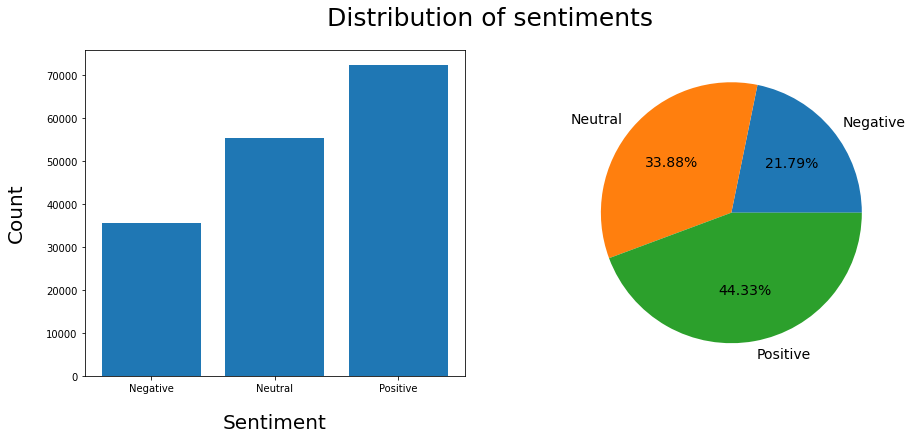

In [8]:
sentiments = class_counts.index
sentiments_count = class_counts["tweet"].values

plt.figure(figsize=(15, 6))
plt.suptitle("Distribution of sentiments", fontsize=25)

plt.subplot(1, 2, 1)
plt.bar(sentiments, sentiments_count)
plt.xlabel("Sentiment", labelpad=20, fontsize=20)
plt.ylabel("Count", labelpad=20, fontsize=20)

plt.subplot(1, 2, 2)
plt.pie(sentiments_count, labels=sentiments, autopct='%1.2f%%', textprops={'fontsize': 14})

plt.show()

In [9]:
reviews_length = [len(str(row["tweet"]).split()) for (index, row) in df.iterrows()]
reviews_length[:5]

[33, 13, 22, 34, 14]

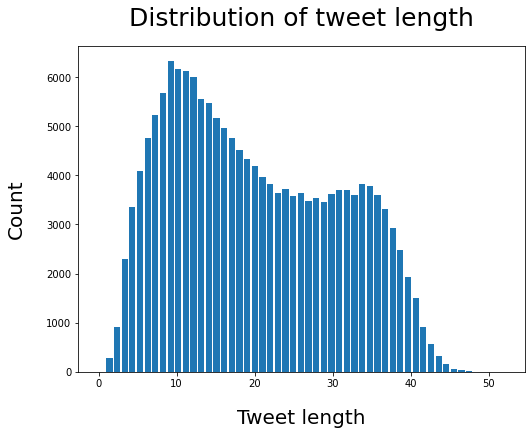

In [10]:
num_bins = np.unique(reviews_length).shape[0]

plt.figure(figsize=(8, 6))
plt.hist(reviews_length, width=0.8, bins=num_bins)
plt.title("Distribution of tweet length", fontsize=25, pad=20)
plt.xlabel("Tweet length", labelpad=20, fontsize=20)
plt.ylabel("Count", labelpad=20, fontsize=20)
plt.show()

# Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocessing(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z0-9]", " ", sentence)
    words = word_tokenize(sentence)
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return words

In [12]:
X = list(map(preprocessing, df['tweet']))
X[0]

['modi',
 'promis',
 'minimum',
 'govern',
 'maximum',
 'govern',
 'expect',
 'begin',
 'difficult',
 'job',
 'reform',
 'state',
 'take',
 'year',
 'get',
 'justic',
 'state',
 'busi',
 'exit',
 'psu',
 'templ']

In [13]:
def word_encoding(X):
    vocab = set()
    for review in X:
        for word in review:
            vocab.add(word)

    counter = 1
    word_to_index = {}
    for word in vocab:
        word_to_index[word] = counter
        counter += 1
        
    X_new = []
    for review in X:
        temp = []
        for word in review:
            temp.append(word_to_index[word])
        X_new.append(temp)
        
    return X_new, word_to_index

X, word_to_index = word_encoding(X)
X[0]

[38481,
 5232,
 60612,
 45880,
 11586,
 45880,
 25803,
 57769,
 39406,
 20103,
 85479,
 26417,
 59086,
 42937,
 61251,
 19627,
 26417,
 60113,
 51493,
 65404,
 27804]

In [14]:
def list_of_tensor(X):
    X_new = []
    for review in X:
        X_new.append(torch.Tensor(review))

    return X_new

X_tensor = list_of_tensor(X)
X_tensor[0]

tensor([38481.,  5232., 60612., 45880., 11586., 45880., 25803., 57769., 39406.,
        20103., 85479., 26417., 59086., 42937., 61251., 19627., 26417., 60113.,
        51493., 65404., 27804.])

In [15]:
X_sequence = pad_sequence(X_tensor, batch_first=True)
X_sequence[0]

tensor([38481.,  5232., 60612., 45880., 11586., 45880., 25803., 57769., 39406.,
        20103., 85479., 26417., 59086., 42937., 61251., 19627., 26417., 60113.,
        51493., 65404., 27804.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.])

In [16]:
encoder = LabelEncoder()

Y = encoder.fit_transform(df["sentiment"])

print(df["sentiment"].values[:5], Y[:5])

['Negative' 'Neutral' 'Positive' 'Positive' 'Positive'] [0 1 2 2 2]


In [17]:
X_array = np.array(X_sequence)
Y_array = np.array(Y)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_array, Y_array, test_size=0.2, random_state=0)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape 

((130375, 43), (130375,), (32594, 43), (32594,))

In [19]:
vocab_size = len(word_to_index)
vocab_size += 1  # including padding represented by zero

vocab_size

87935

In [20]:
# Checking if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# LSTM Model

In [21]:
class LSTM(nn.Module):
  
    def __init__(self, vocab_size):
        super().__init__()
        
        self.hidden_size = 64
        self.num_layers = 1
        
        self.embedding = nn.Embedding(vocab_size, 32)
        self.lstm = nn.LSTM(32, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 3)

    def forward(self, x):
        batch_size = x.shape[0]

        x_embedding = self.embedding(x)
    
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)

        out, hidden_state = self.lstm(x_embedding, (h0, c0))

        last_output = out[:, -1, :]

        final_output = self.linear(last_output)

        return final_output

In [22]:
lstm_model = LSTM(vocab_size).to(device)

### Hyperparameters

In [23]:
n_epochs = 100
batch_size = 64
learning_rate = 0.0001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate) 

## Training

In [24]:
def training(model, optimizer, loss_function, batch_size, n_epochs, X, Y):
    
    for epoch in range(n_epochs):
        
        size = X.shape[0]

        for i in range(0, size, batch_size):
      
            start = i
            end = i + batch_size
            end = min(size, end)

            X_batch = X[start:end]
            Y_batch = Y[start:end]

            prediction = model.forward(X_batch)

            loss = loss_function(prediction, Y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                prediction = model.forward(X)
                Y_pred = torch.argmax(prediction, dim=1)
                Y_pred_cpu = Y_pred.cpu().numpy()
                Y_actual_cpu = Y.cpu().numpy()
                print(f"Epoch {epoch+1}:- Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.int32).to(device)
Y_train_tensor = torch.tensor(Y_train).to(device)

In [26]:
training(lstm_model, optimizer, loss_function, batch_size, n_epochs, X_train_tensor, Y_train_tensor)

Epoch 10:- Accuracy: 71.90412272291466
Epoch 20:- Accuracy: 82.33403643336528
Epoch 30:- Accuracy: 86.26577181208054
Epoch 40:- Accuracy: 87.40862895493768
Epoch 50:- Accuracy: 89.42128475551294
Epoch 60:- Accuracy: 89.9535953978907
Epoch 70:- Accuracy: 90.8648130393097
Epoch 80:- Accuracy: 91.73000958772771
Epoch 90:- Accuracy: 92.81150527325023
Epoch 100:- Accuracy: 93.38446788111217


## Testing

In [27]:
def testing(model, X, Y):
    with torch.no_grad():
        prediction = model.forward(X)
        Y_pred = torch.argmax(prediction, dim=1)
        Y_pred_cpu = Y_pred.cpu().numpy()
        Y_actual_cpu = Y.cpu().numpy()
        print(f"Testing Accuracy: {accuracy_score(Y_actual_cpu, Y_pred_cpu)*100}")

In [28]:
X_test_tensor = torch.tensor(X_test, dtype=torch.int32).to(device)
Y_test_tensor = torch.tensor(Y_test).to(device)

In [29]:
testing(lstm_model, X_test_tensor, Y_test_tensor)

Testing Accuracy: 80.53629502362398
